In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from darts.models import TFTModel
from pytorch_lightning.callbacks import EarlyStopping
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from sklearn.metrics import mean_absolute_percentage_error
import datetime


In [163]:
#import weather data Houston, CST/CDT, 2017-01-01 to 2022-12-30
weather_data = pd.read_csv('WeatherData/HOU.csv',
                           usecols=["valid","tmpf","dwpf","relh","p01i","sknt","feel"]) 

# rename columns    
weather_data.rename(columns={'valid': 'time','tmpf' : 'temp','dwpf' : 'dew_point','relh' : 'humidity', 'p01i' : 'precip','sknt' : 'wind_speed','feel' : 'feels_like' }, inplace=True)

# replace M (missing data) with Nan
weather_data.replace(to_replace='M', value=np.nan, inplace=True)

# replace T (trace precip) with 0.00
weather_data['precip'].replace(to_replace='T', value=0.00, inplace=True)

# # remove all rows containing Nan
weather_data.dropna(axis=0, how='any', inplace=True)

# convert values to float datatypes
weather_data = weather_data.astype({'temp':'float','dew_point':'float','humidity':'float','precip':'float','wind_speed':'float','feels_like':'float' })

# convert time to datetime datatype
weather_data['time'] = pd.to_datetime(weather_data['time'])

# resample weather dataframe by hour to match load dataset
weather_df = weather_data.resample('1H', on='time').mean()

# remove all rows containing Nan after resample
weather_df.dropna(axis=0, how='any', inplace=True)

# remove humidity and precipitation columns
weather_df.drop(columns=['humidity', 'precip'], axis=1, inplace=True)

In [164]:
# weather_df.drop(columns=['humidity', 'precip'], axis=1, inplace=True)

display(weather_df)

temp  dew_point  wind_speed  feels_like
time                                                        
2017-01-01 00:00:00  63.0       62.1         3.0        63.0
2017-01-01 01:00:00  63.0       63.0         3.0        63.0
2017-01-01 02:00:00  64.0       63.0         0.0        64.0
2017-01-01 03:00:00  64.0       63.0         0.0        64.0
2017-01-01 04:00:00  63.0       62.1         0.0        63.0
...                   ...        ...         ...         ...
2022-12-30 19:00:00  63.0       57.9         4.0        63.0
2022-12-30 20:00:00  62.1       57.9         4.0        62.1
2022-12-30 21:00:00  62.1       57.9         0.0        62.1
2022-12-30 22:00:00  60.1       57.0         5.0        60.1
2022-12-30 23:00:00  59.0       55.9         0.0        59.0

[52304 rows x 4 columns]

In [165]:
# import load archive data
load_2017 = pd.read_excel('LoadData/Native_Load_2017.xlsx')
load_2017.rename(columns={'Hour Ending' : 'HourEnding'}, inplace=True)
load_2018 = pd.read_excel('LoadData/Native_Load_2018.xlsx')
load_2019 = pd.read_excel('LoadData/Native_Load_2019.xlsx')
load_2020 = pd.read_excel('LoadData/Native_Load_2020.xlsx')
load_2021 = pd.read_excel('LoadData/Native_Load_2021.xlsx')
load_2021.rename(columns={'Hour Ending' : 'HourEnding'}, inplace=True)
load_2022 = pd.read_excel('LoadData/Native_Load_2022.xlsx')
load_2022.rename(columns={'Hour Ending': "HourEnding"}, inplace=True)

dataframes = [load_2017,load_2018, load_2019, load_2020, load_2021, load_2022]

# concat files, include only load usage for Coastal area
load_test_data = pd.concat(dataframes, ignore_index=True)
load_test_data = load_test_data[['HourEnding', 'COAST']]

# change column names
load_test_data.rename(columns={'HourEnding' : 'time', 'COAST' : 'load'}, inplace=True)

# replace 2400 with 0:00 and convert to datetime type
load_test_data['time'] = load_test_data['time'].replace('24:00', '00:00', regex=True)
load_test_data['time'] = pd.to_datetime(load_test_data['time'])

load_df = load_test_data.resample('1H', on='time').mean()

# drop null values
load_df.dropna(axis=0, how='any', inplace=True)

c:\Users\Adina\anaconda3\envs\capstone\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning:

tzname DST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



In [166]:
# merge datasets
left = weather_df
right = load_df
full_df = pd.merge(left, right, on=['time'])

In [ ]:
# line plots load by year

# resampled by month
load_year_17 = full_df['2017-01' : '2017-12'].resample('M').mean()
load_year_18 = full_df['2018-01' : '2018-12'].resample('M').mean()
load_year_19 = full_df['2019-01' : '2019-12'].resample('M').mean()
load_year_20 = full_df['2020-01' : '2020-12'].resample('M').mean()
load_year_21 = full_df['2021-01' : '2021-12'].resample('M').mean()

# create line plots
fig = px.line(y=load_year_17['load'],labels={'x':'Month', 'y':'Energy Consumption (MW)'},title='Monthly Energy Consumption in 2017')
fig1 = px.line(y=load_year_18['load'],labels={'x':'Month', 'y':'Energy Consumption (MW)'},title='Monthly Energy Consumption in 2018')
fig2 = px.line(y=load_year_19['load'],labels={'x':'Month', 'y':'Energy Consumption (MW)'},title='Monthly Energy Consumption in 2019')
fig3 = px.line(y=load_year_20['load'],labels={'x':'Month', 'y':'Energy Consumption (MW)'},title='Monthly Energy Consumption in 2020')
fig4 = px.line(y=load_year_21['load'],labels={'x':'Month', 'y':'Energy Consumption (MW)'},title='Monthly Energy Consumption in 2021')

# center title
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500)
fig1.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500)
fig2.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500)
fig3.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500)
fig4.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500)

# x axis tick labels
fig.update_xaxes(tickvals=(np.arange(12)),ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig1.update_xaxes(tickvals=(np.arange(12)),ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig2.update_xaxes(tickvals=(np.arange(12)),ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig3.update_xaxes(tickvals=(np.arange(12)),ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
fig4.update_xaxes(tickvals=(np.arange(12)),ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# fig.show()
# fig1.show()
# fig2.show()
# fig3.show()
# fig4.show()


Monthly Energy Consumption by Year

![image.png](2017.png) ![image.png](2018.png)
![image.png](2019.png) ![image.png](2020.png)
![image.png](2021.png)
        

In [168]:
# correlation matrix for target & features
corr_matrix = px.imshow(full_df.corr(), color_continuous_scale='mint', title='Correlation Matrix')

corr_matrix.update_layout(title={'y':0.9,'x':0.5,'xanchor':'center','yanchor':'top'}, width=600, height=500) # center title


corr_matrix.show()

Highest correlations:

1. Load & Temperature
2. Load & Feels Like
3. Load & Dew Point

![image.png](correlationamatrix.png)

In [169]:
# date to split train/test sets
split_date = pd.Timestamp('20220101')

# timeseries of merged datasets
timeseries_df = TimeSeries.from_dataframe(full_df, freq='1H')

In [170]:
# create timeseries for load date
timeseries_target = TimeSeries.from_dataframe(load_df, fill_missing_dates=True, freq='1H', fillna_value=0.0)

# split load train/test datasets
train_target, test_target = timeseries_target.split_after(split_date)

# scale to training set
target_transformer = Scaler()
train_target_transformed = target_transformer.fit_transform(train_target)
test_target_transformed = target_transformer.transform(test_target)
timeseries_target_transformed = target_transformer.transform(timeseries_target)



In [171]:

# create timeseries for weather features
timeseries_features = TimeSeries.from_dataframe(weather_df, fill_missing_dates=True, freq='1H', fillna_value=0.0)

# split train/test weather sets
train_features, test_features = timeseries_features.split_after(split_date)

# scale to training set
feature_transformer = Scaler()
train_features_transformed = feature_transformer.fit_transform(train_features)
test_features_transformed = feature_transformer.transform(test_features)
timeseries_features_transformed = feature_transformer.transform(timeseries_features)

# past covariates 
past_covariates = train_features_transformed

In [216]:
# time covariates creation
time_cov = datetime_attribute_timeseries(timeseries_target.time_index, attribute='hour')
time_cov = time_cov.stack(datetime_attribute_timeseries(time_cov.time_index, attribute='day_of_week'))
time_cov = time_cov.stack(datetime_attribute_timeseries(time_cov.time_index, attribute='month'))
time_cov = time_cov.stack(datetime_attribute_timeseries(time_cov.time_index, attribute='year'))

time_cov = time_cov.add_holidays(country_code='US')

# convert to dataframe to add other features
time_cov_df = time_cov.pd_dataframe()

# add seasons
time_cov_df['is_summer'] = np.where((time_cov_df.index.month >= 6) & (time_cov_df.index.month <= 8),1,0)       # summer months 6-8
time_cov_df['is_winter'] = np.where((time_cov_df.index.month == 12) | (time_cov_df.index.month <= 2), 1, 0)    # winter months 12-2
time_cov_df['is_spring'] = np.where((time_cov_df.index.month >= 3) & (time_cov_df.index.month <= 5), 1, 0)     # spring months 3-5
time_cov_df['is_autumn'] = np.where((time_cov_df.index.month >= 9) & (time_cov_df.index.month <= 11), 1, 0)    # autumn months 9-11

# add weekends
time_cov_df['is_weekend'] = np.where((time_cov_df.index.weekday >= 5), 1, 0) 

# back to Timeseries
time_cov = TimeSeries.from_dataframe(time_cov_df)

# split time feature train/test sets
time_cov_train, time_cov_test = time_cov.split_after(split_date)

# scale time covariates 
time_transformer = Scaler()
time_cov_train_transformed = time_transformer.fit_transform(time_cov_train)
time_cov_test_transformed = time_transformer.transform(time_cov_test)
time_cov_transformed = time_transformer.transform(time_cov)

# define future covariates
future_covariates = time_cov_transformed # time features

In [223]:
# model
model_name = 'forecast_model'

#hyperparamters
LOAD=False
EPOCHS=2        #training cycles
INLEN=24         #number of inputs/columns
OUTLEN=24        #forecast periods/output size
HIDDEN=32        #hidden layer
LSTMLAYERS=1    
ATTH=1          #attention heads
DROPOUT=0.1     #dropout rate
BATCH=64        #batch size  
RAND=40         #random seed
N_SAMPLES=100   #prediction samples

In [ ]:
early_stop = EarlyStopping(
    monitor='train_loss',
    patience=5,
    min_delta=0.05,
    mode='min'
)

pl_trainer_kwargs = {'callbacks': early_stop}

In [253]:
# model setup with hyperparameterrs
forecast_model = TFTModel(
    input_chunk_length=INLEN,
    output_chunk_length=OUTLEN,
    hidden_size=HIDDEN,
    lstm_layers=LSTMLAYERS,
    num_attention_heads=ATTH,
    dropout=DROPOUT,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    random_state=RAND,
    add_encoders={
        "cyclic": {"future": ["hour", "dayofweek", "month"]},
        'transformer': Scaler()
    },
    optimizer_kwargs={"lr": 1e-3}
)

In [254]:
display(train_target_transformed.pd_dataframe())

component                load
time                         
2017-01-01 00:00:00  0.436942
2017-01-01 01:00:00  0.413612
2017-01-01 02:00:00  0.403164
2017-01-01 03:00:00  0.391719
2017-01-01 04:00:00  0.382831
...                       ...
2021-12-31 20:00:00  0.655189
2021-12-31 21:00:00  0.635060
2021-12-31 22:00:00  0.617047
2021-12-31 23:00:00  0.600034
2022-01-01 00:00:00  0.552474

[43825 rows x 1 columns]

In [255]:
# train model
forecast_model.fit(train_target_transformed,verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.1 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 6.0 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 4.3 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [256]:
path = F"Models\{model_name}"
forecast_model.save(path)

In [220]:
forecast_model = TFTModel.load('Models\\forecast_model')

AttributeError: module 'darts.models.forecasting.tft_model' has no attribute ''

In [38]:
def model_eval(model, n, actual_series, test_series):
    pred_series = model.predict(n=n, num_samples=N_SAMPLES)

    plt.figure(figsize=(15,6))
    actual_series.plot(label='actual')
    pred_series.plot(label='predicted')

    plt.title('MAPE: {: .2f}%'.format(mape(test_series,pred_series)))
    plt.legend()

In [286]:
# prediction past_covariates=test_features_transformed,

prediction_start_date = pd.Timestamp('20220105')
prediction_end_date = pd.Timestamp('20221225')
prediction_series = test_target_transformed.drop_after(prediction_start_date)

prediction = forecast_model.predict(series=prediction_series,n= 24 * (prediction_end_date - prediction_start_date).days)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

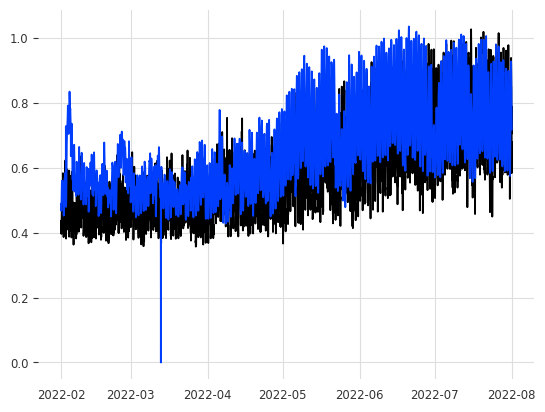

In [288]:
j_timestamp_start = pd.Timestamp('20220201')
j_timestamp_end = pd.Timestamp('20220801')

jan_pred = prediction.slice(j_timestamp_start, j_timestamp_end)

pred_line = jan_pred.pd_dataframe()
jan_actual = test_target_transformed.slice(j_timestamp_start, j_timestamp_end)
actual_line = test_target_transformed.slice(j_timestamp_start, j_timestamp_end).pd_dataframe()

plt.plot(pred_line, label='predicted')
plt.plot(actual_line, label='actual')

plt.title('MAPE: {: .2f}%'.format(mape(jan_actual,jan_pred)))

plt.legend()
plt.ylabel('Energy')
plt.xlabel('Time')
plt.show()

# test_target_transformed.slice(j_timestamp_start, j_timestamp_end).plot()



In [265]:
from scipy.ndimage.filters import gaussian_filter1d
pred_line['load_smooth'] = gaussian_filter1d(pred_line['load'], sigma=1)
pred_fig = px.line(y=pred_line['load_smooth'], x=pred_line.index, labels={'x':'Time', 'y':'Energy Consumption (MW)'},title='Prediction for May-June for Model 1')

pred_fig.add_scatter(y=actual_line['load'], x=actual_line.index)
pred_fig.show()

C:\Users\Adina\AppData\Local\Temp\ipykernel_35176\1107596111.py:1: DeprecationWarning:

Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.



In [273]:
weather_df

temp  dew_point  wind_speed  feels_like
time                                                        
2017-01-01 00:00:00  63.0       62.1         3.0        63.0
2017-01-01 01:00:00  63.0       63.0         3.0        63.0
2017-01-01 02:00:00  64.0       63.0         0.0        64.0
2017-01-01 03:00:00  64.0       63.0         0.0        64.0
2017-01-01 04:00:00  63.0       62.1         0.0        63.0
...                   ...        ...         ...         ...
2022-12-30 19:00:00  63.0       57.9         4.0        63.0
2022-12-30 20:00:00  62.1       57.9         4.0        62.1
2022-12-30 21:00:00  62.1       57.9         0.0        62.1
2022-12-30 22:00:00  60.1       57.0         5.0        60.1
2022-12-30 23:00:00  59.0       55.9         0.0        59.0

[52304 rows x 4 columns]

In [280]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=load_df.index, y=load_df['load']),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=weather_df.index, y=weather_df['temp']),
    secondary_y=True,
)

fig.show()


In [108]:
# prediction.plot(label='Predicted')
# test_target_transformed['2022-02-01' : '2022-02-02'].plot()

# val_set = target_transformer.inverse_transform(test_target_transformed)

# display(val_set)

# val_set['time'].plot()

# plt.legend()

In [ ]:
display(prediction)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

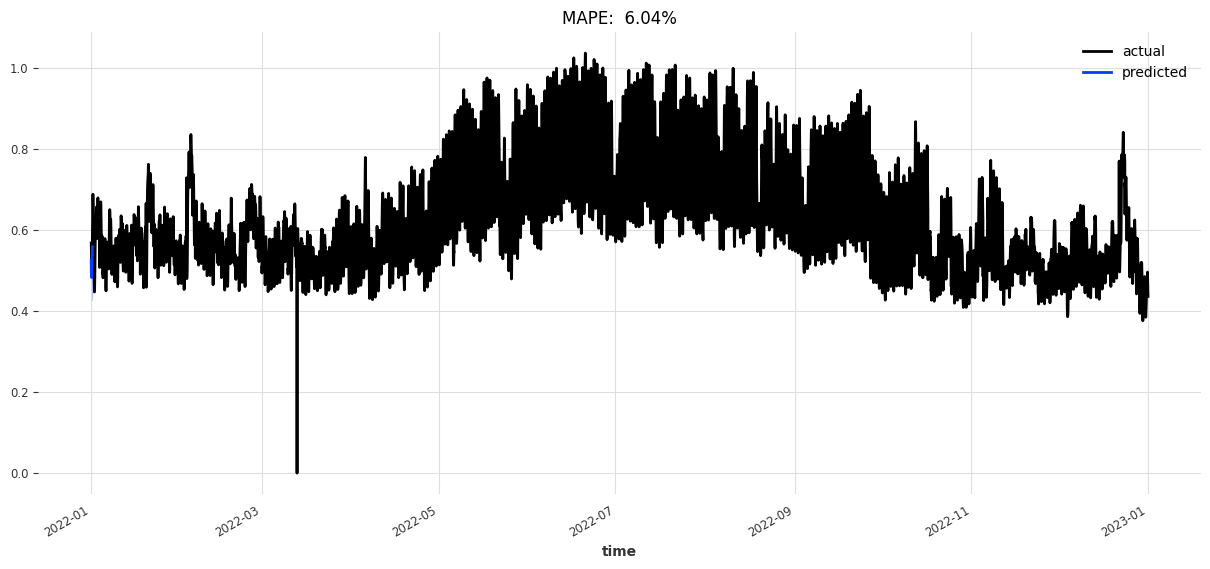

In [39]:
model_eval(forecast_model, 12, test_target_transformed, test_target_transformed)